# Emotion Classification in short texts with BERT

Applying BERT to the problem of multiclass text classification. Our dataset consists of written
dialogs, messages and short stories. Each dialog utterance/message is labeled with one of the five
emotion categories: joy, anger, sadness, fear, neutral.

## Workflow:

1. Import Data
2. Data preprocessing and downloading BERT
3. Training and validation
4. Saving the model

Multiclass text classification with BERT and [ktrain](https://github.com/amaiya/ktrain). Use google
colab for a free GPU

👋 **Let's start**


In [1]:
!pip install ktrain


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np

import ktrain
from ktrain import text

from sklearn.model_selection import train_test_split

## 1. Import Data


<Axes: xlabel='emotion'>

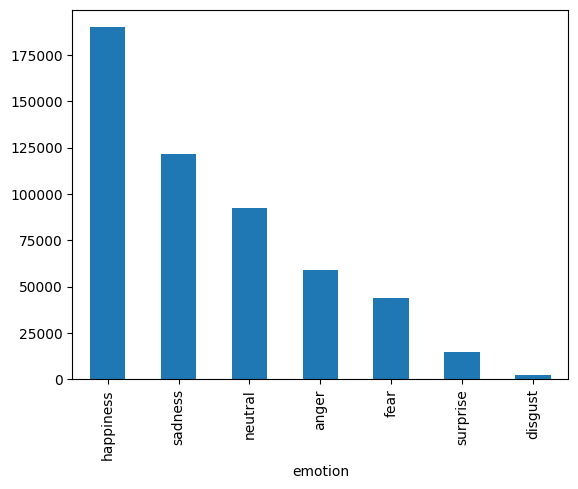

In [3]:
df = pd.read_csv("emotion_data_merged_3.csv")
# df = df.sample(frac=1).reset_index(drop=True)
df = df.dropna()
# df = df[:50000]

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    df["sentence"], df["emotion"], test_size=0.2, random_state=42
)



class_names = [
    "happiness",
    "sadness",
    "fear",
    "anger",
    "surprise",
    "disgust",
    "neutral",
]



# print(data.Emotion.value_counts())

df["emotion"].value_counts().plot(kind="bar")



# data.head(10)

In [4]:
encoding = {
    "happiness": 0,
    "sadness": 1,
    "fear": 2,
    "anger": 3,
    "surprise": 4,
    "disgust": 5,
    "neutral": 6,
}

# Integer values for each class
y_train = [encoding[x] for x in y_train]
y_test = [encoding[x] for x in y_test]

X_train = X_train.tolist()
X_test = X_test.tolist()

## 2. Data preprocessing

- The text must be preprocessed in a specific way for use with BERT. This is accomplished by setting
  preprocess_mode to ‘bert’. The BERT model and vocabulary will be automatically downloaded

- BERT can handle a maximum length of 512, but let's use less to reduce memory and improve speed.


In [5]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_array(
    x_train=X_train,
    y_train=y_train,
    x_test=X_test,
    y_test=y_test,
    class_names=class_names,
    preprocess_mode="bert",
    maxlen=350,
    max_features=35000,
)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


## 2. Training and validation


Loading the pretrained BERT for text classification


In [6]:
model = text.text_classifier("bert", train_data=(x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 350


/usr/local/lib/python3.11/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.


Wrap it in a Learner object


In [7]:
learner = ktrain.get_learner(
    model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=6
)

INFO: Sharding callback duration: 115


Train the model. More about tuning learning rates
[here](https://github.com/amaiya/ktrain/blob/master/tutorial-02-tuning-learning-rates.ipynb)


In [ ]:
learner.fit_onecycle(2e-5, 3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
31441/69769 [============>.................] - ETA: 1:21:50 - loss: 0.2913 - accuracy: 0.9026

Validation


In [ ]:
learner.validate(val_data=(x_test, y_test), class_names=class_names)

#### Testing with other inputs


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.get_classes()

In [ ]:
import time

message = "I just broke up with my boyfriend"

start_time = time.time()
prediction = predictor.predict(message)

print("predicted: {} ({:.2f})".format(prediction, (time.time() - start_time)))

In [ ]:
df_prediction = pd.read_csv("test_group.csv", sep="\t")

sentences_to_predict = df_prediction['sentence'].tolist()

predicted_emotions = [predictor.predict(sentence) for sentence in sentences_to_predict]

df_prediction['emotion'] = predicted_emotions

df_prediction = df_prediction[["id", "emotion"]]

df_prediction.to_csv("bert_full_predictions.csv", index=False)

In [ ]:
df_prediction.head()

## 4. Saving Bert model


In [ ]:
# let's save the predictor for later use
predictor.save("models/bert_full")

Done! to reload the predictor use: ktrain.load_predictor
